<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


## Подготовка

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from statsmodels.tsa.seasonal import seasonal_decompose

In [88]:
taxi = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [89]:
taxi.sort_index(inplace=True)

In [90]:
taxi = taxi.resample('1H').sum()

In [91]:
data = taxi.copy() #копируем данные. Taxi - для анализа, data - для обучения

## Анализ

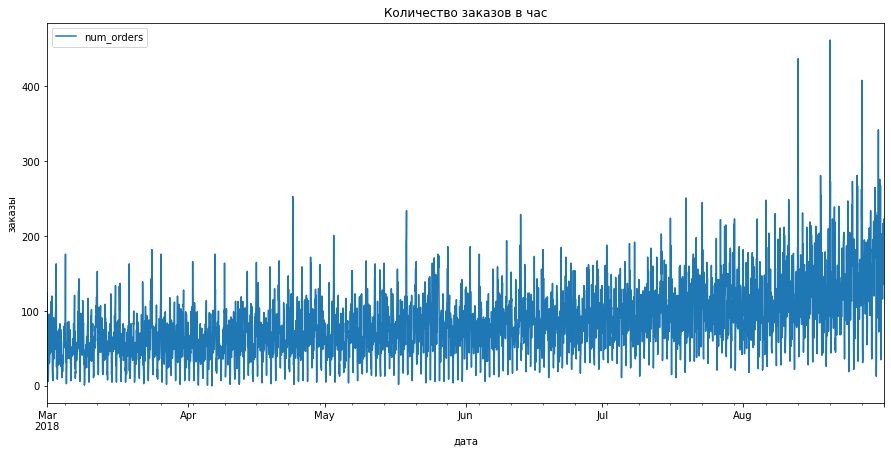

In [92]:
taxi.plot(figsize = (15,7),
         title = 'Количество заказов в час',
         xlabel = 'дата',
         ylabel = 'заказы');

Видны сильные колебания и нестационарность ряда

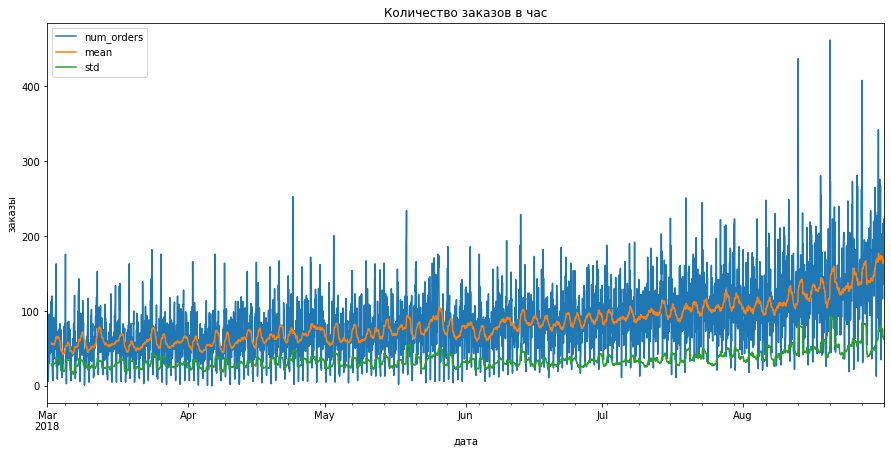

In [93]:
taxi['mean'] = taxi['num_orders'].rolling(24).mean()
taxi['std'] = taxi['num_orders'].rolling(24).std()
taxi.plot(figsize = (15,7),
         title = 'Количество заказов в час',
         xlabel = 'дата',
         ylabel = 'заказы');

На графике стало заметно, как растет среднее число заказов в час. Стандартное отклонение тоже меняется, но нетак сильно. 

In [94]:
decomposed_week = seasonal_decompose(taxi['num_orders'], period = 7*24)
decomposed_day = seasonal_decompose(taxi['num_orders'], period = 24)


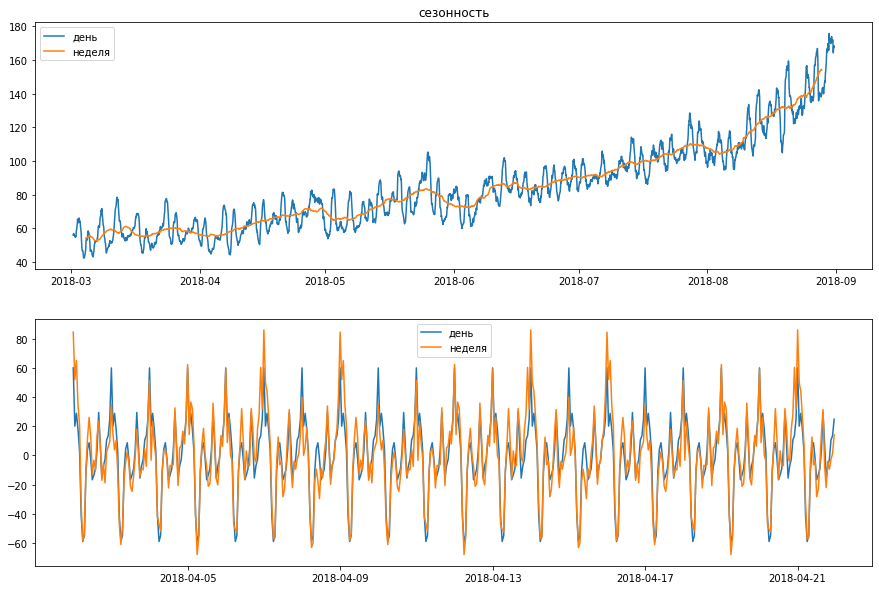

In [249]:
fig, axes = plt.subplots(2, 1, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)


axes[0].plot(decomposed_day.trend, label='день')
axes[0].plot(decomposed_week.trend, label='неделя')
axes[0].legend()
axes[0].set_title('тренд')

axes[1].plot(decomposed_day.seasonal['2018-04-02':'2018-04-21'], label='день')
axes[1].plot(decomposed_week.seasonal['2018-04-02':'2018-04-21'], label='неделя')
axes[1].legend()
axes[0].set_title('сезонность')

plt.show()


Теперь хорошо виден тренд на увеличение числа заказов и колебания, которые происходят с периодом в неделю.
Видны также три пика заказов в течение дня - утром, днем и самый большой вечером. 
Заметно повышение числа заказов в вечерние часы пятницы и воскресенья

## Обучение

In [96]:
#функция для подготовки признаков

def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Чем больше максимальный рзамер отставания, тем лучше должна быть модель, но тем медленнее она будет работать. В качестве компромисса выберем 72 часа

In [97]:
make_features(data,72, 72)

In [98]:
#разделение выборки на тестовую и обучающую
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()
#выделение целевого признака

X_train = train.drop(['num_orders'], axis =1)
X_test = test.drop('num_orders', axis =1)

y_train = train['num_orders']
y_test = test['num_orders']

In [99]:
#масштабирование признаков

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


Будем использовать три модели - линейную регрессию, случайный лес и CatBoosting

In [100]:
#del lr

In [101]:
lr = LinearRegression()
lr.fit(X_train,y_train)



RandomForestRegressor(random_state=1)

In [135]:
%%time
rfr = RandomForestRegressor(random_state=1)

rfr_parameters = {'max_depth'    : [10,20,30],
                  'n_estimators' : [40,50,60]
                 }

grid_rfr = GridSearchCV(estimator=rfr, param_grid = rfr_parameters, cv = TimeSeriesSplit(), n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_rfr.fit(X_train, y_train);

CPU times: user 2min 26s, sys: 310 ms, total: 2min 26s
Wall time: 2min 27s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [40, 50, 60]},
             scoring='neg_root_mean_squared_error')

In [137]:
grid_rfr.best_params_

{'max_depth': 30, 'n_estimators': 60}

In [138]:
rfr = RandomForestRegressor(random_state=1,max_depth= 30, n_estimators= 60).fit(X_train, y_train)


40.82120108638619

In [102]:

cbr = CatBoostRegressor(silent = True, random_state =1)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]}


In [104]:
grid_search_result = cbr.grid_search(grid, X=X_train, y=y_train, cv = TimeSeriesSplit(),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 30.7405978
bestIteration = 530

0:	loss: 30.7405978	best: 30.7405978 (0)	total: 7.15s	remaining: 35.8s

bestTest = 31.47550721
bestIteration = 593

1:	loss: 31.4755072	best: 30.7405978 (0)	total: 13.3s	remaining: 26.7s

bestTest = 31.16393607
bestIteration = 964

2:	loss: 31.1639361	best: 30.7405978 (0)	total: 29.6s	remaining: 29.6s

bestTest = 31.04675231
bestIteration = 252

3:	loss: 31.0467523	best: 30.7405978 (0)	total: 46s	remaining: 23s

bestTest = 35.11886804
bestIteration = 959

4:	loss: 35.1188680	best: 30.7405978 (0)	total: 3m 11s	remaining: 38.2s

bestTest = 35.90084803
bestIteration = 962

5:	loss: 35.9008480	best: 30.7405978 (0)	total: 5m 40s	remaining: 0us
Estimating final quality...
Training on fold [0/5]

bestTest = 21.30310416
bestIteration = 421

Training on fold [1/5]

bestTest = 20.64118394
bestIteration = 999

Training on fold [2/5]

bestTest = 21.70403273
bestIteration = 998

Training on fold [3/5]

bestTest = 23.2588171
bestIteration = 998

Training o

## Тестирование

In [139]:
models = [cbr,lr,rfr]
results = pd.DataFrame(columns=['model','rmse'])

for model in models:
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test,y_pred)**.5
    results = results.append({'model': model,
                             'RMSE': rmse}, 
                             ignore_index=True)  
results

,model,rmse,RMSE
0,<catboost.core.CatBoostRegressor object at 0x7...,NaN,38.913330
1,LinearRegression(),NaN,41.223303
2,"(DecisionTreeRegressor(max_depth=30, max_featu...",NaN,40.821201


In [ ]:
y_pred = cbr.predict(X_test)
prediction = pd.DataFrame(index = y_test.index,data = y_pred)

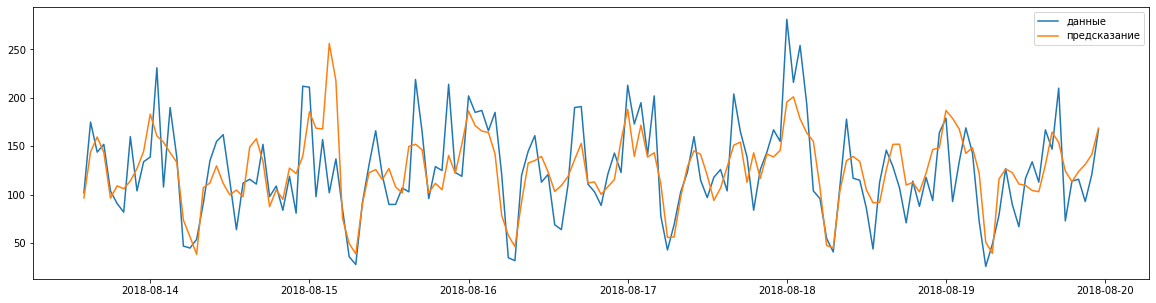

In [241]:
plt.figure(figsize=(20,5))
plt.plot(y_test['2018-08-13':'2018-08-19'], label='данные') #график за неделю с 13 по 19
plt.plot(prediction['2018-08-13':'2018-08-19'], label='предсказание')
plt.legend()

plt.show()

**Выводы**

 - проанализированы данные, выделены тренд и сезонные компоненты
 - обнаружено плавное повышение числа заказов за рассматриваемый период
 - обнаружены три пика заказов в течение дня - утром, днем и вечером
 - обнаружены два пика в течение недели - в пятницу и воскресенье
 - Обучены разные модели с разными гиперпараметрами
 - Все три модели позволяют достигнуть RMSE менее 48
 - лучше всех справляется CatBoosting
 - Для предсказания количества заказов такси на следующий час рекомендуется использовать CatBoosting с указанными параметрами. 